In [2]:
# ============================================================
# HERCULES-V2X — FULL 4-LAYER HIERARCHICAL GRID
# AMP + EarlyStopping + Adaptive LR + Memory-Efficient FedAvg
# ============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import itertools, copy, time, warnings
warnings.filterwarnings("ignore")

# ============================================================
# GPU SETUP
# ============================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
print("Running on:", DEVICE)

# ============================================================
# DATA LOADING
# ============================================================

DOS="/kaggle/input/car-hacking-dataset/DoS_dataset.csv"
FUZZY="/kaggle/input/car-hacking-dataset/Fuzzy_dataset.csv"
NORMAL="/kaggle/input/car-hacking-dataset/normal_run_data.txt"

def load_attack(path):
    df = pd.read_csv(path, header=None, engine="python",
                     sep=",", on_bad_lines="skip", dtype=str)
    df = df.iloc[:, :12]
    df.columns = ["timestamp","can_id","dlc",
                  "b0","b1","b2","b3","b4","b5","b6","b7","flag"]
    df["label"] = 1
    return df

def load_normal(path):
    rows=[]
    with open(path) as f:
        for line in f:
            parts=line.strip().split()
            if len(parts)<15: continue
            try:
                timestamp=float(parts[1])
                can_id=parts[3]
                dlc=int(parts[6])
                payload=parts[7:15]
                rows.append([timestamp,can_id,dlc]+payload[:8]+["R",0])
            except:
                continue
    cols=["timestamp","can_id","dlc",
          "b0","b1","b2","b3","b4","b5","b6","b7","flag","label"]
    return pd.DataFrame(rows,columns=cols)

df=pd.concat([load_attack(DOS),
              load_attack(FUZZY),
              load_normal(NORMAL)])

df=df.fillna(0)

le=LabelEncoder()
df["can_id"]=le.fit_transform(df["can_id"])

payload_cols=["b0","b1","b2","b3","b4","b5","b6","b7"]
for col in payload_cols:
    df[col]=pd.to_numeric(df[col],errors="coerce").fillna(0)

features=["can_id"]+payload_cols
X=df[features].values
y=df["label"].values

scaler=StandardScaler()
X=scaler.fit_transform(X)

X=torch.tensor(X,dtype=torch.float32,device=DEVICE)
y=torch.tensor(y,dtype=torch.float32,device=DEVICE)

# ============================================================
# LAYER I — STATISTICAL GUARD
# ============================================================

def statistical_guard(X,threshold):
    scores=torch.abs(X).mean(dim=1)
    flags=(scores>threshold)
    return flags

# ============================================================
# LAYER II — MODEL
# ============================================================

class HerculesNet(nn.Module):
    def __init__(self,input_dim,hidden):
        super().__init__()
        self.fc1=nn.Linear(input_dim,hidden)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(hidden,1)
    def forward(self,x):
        return self.fc2(self.relu(self.fc1(x)))

# ============================================================
# LAYER III — RISK OBJECTIVE
# ============================================================

def risk_objective(preds,cw,rw):
    risk=preds.mean()
    cost=(preds>0.5).float().mean()
    return cw*cost + rw*risk

# ============================================================
# LAYER IV — FEDERATED TRAINING (OPTIMIZED)
# ============================================================

def federated_train(X,y,hidden,clients,rounds,
                    local_epochs,epsilon):

    client_idx=torch.chunk(torch.arange(len(X)),clients)
    global_model=HerculesNet(X.shape[1],hidden).to(DEVICE)

    scaler=torch.cuda.amp.GradScaler()

    for r in range(rounds):

        agg_state=None

        for c in client_idx:

            model=copy.deepcopy(global_model)

            opt=optim.Adam(model.parameters(),lr=0.001)
            scheduler=optim.lr_scheduler.ReduceLROnPlateau(
                opt,mode="min",factor=0.5,patience=1)

            crit=nn.BCEWithLogitsLoss()

            idx=c.cpu().numpy()
            tr,vl=train_test_split(idx,test_size=0.1,
                                   stratify=y[idx].cpu())

            train_loader=DataLoader(
                TensorDataset(X[tr],y[tr]),
                batch_size=1024,shuffle=True)

            val_loader=DataLoader(
                TensorDataset(X[vl],y[vl]),
                batch_size=2048)

            for epoch in range(local_epochs):

                model.train()
                for xb,yb in train_loader:
                    yb=yb.unsqueeze(1)

                    with torch.cuda.amp.autocast():
                        loss=crit(model(xb),yb)

                    opt.zero_grad()
                    scaler.scale(loss).backward()
                    scaler.step(opt)
                    scaler.update()

                # validation
                model.eval()
                val_loss=0
                with torch.no_grad():
                    for xb,yb in val_loader:
                        yb=yb.unsqueeze(1)
                        with torch.cuda.amp.autocast():
                            val_loss+=crit(model(xb),yb).item()

                scheduler.step(val_loss)

            state=model.state_dict()

            if epsilon>0:
                for k in state:
                    state[k].add_(
                        torch.normal(0,epsilon,
                                     size=state[k].shape,
                                     device=DEVICE)
                    )

            if agg_state is None:
                agg_state=state
            else:
                for k in agg_state:
                    agg_state[k]+=state[k]

            del model
            torch.cuda.empty_cache()

        for k in agg_state:
            agg_state[k]/=clients

        global_model.load_state_dict(agg_state)

    return global_model

# ============================================================
# 4-LAYER ABLATION GRID
# ============================================================

L1_thresholds=[2.0,2.5]
L2_hidden=[32,64]
L3_weights=[(0.4,0.6),(0.6,0.4)]
L4_clients=[2,4]
L4_rounds=[2]
L4_eps=[0.0,0.01]

results=[]

grid=list(itertools.product(
    L1_thresholds,
    L2_hidden,
    L3_weights,
    L4_clients,
    L4_rounds,
    L4_eps
))

print("Total Configurations:",len(grid))

for th,hidden,(cw,rw),clients,rounds,eps in grid:

    print(f"\nConfig: th={th}, h={hidden}, "
          f"cw={cw}, rw={rw}, "
          f"clients={clients}, eps={eps}")

    flags=statistical_guard(X,th)

    X_f=X[~flags]
    y_f=y[~flags]

    if len(torch.unique(y_f))<2:
        continue

    train_idx,test_idx=train_test_split(
        torch.arange(len(X_f)).cpu(),
        test_size=0.2,
        stratify=y_f.cpu())

    X_train=X_f[train_idx]
    y_train=y_f[train_idx]
    X_test=X_f[test_idx]
    y_test=y_f[test_idx]

    start=time.time()

    model=federated_train(
        X_train,y_train,
        hidden,clients,rounds,
        local_epochs=2,
        epsilon=eps
    )

    train_time=time.time()-start

    model.eval()
    with torch.no_grad():
        preds=torch.sigmoid(model(X_test)).flatten()

    binary=(preds>0.5).cpu().numpy()
    preds_np=preds.cpu().numpy()

    metrics={
        "Threshold":th,
        "Hidden":hidden,
        "CostWeight":cw,
        "RiskWeight":rw,
        "Clients":clients,
        "Epsilon":eps,
        "Accuracy":accuracy_score(y_test.cpu(),binary),
        "F1":f1_score(y_test.cpu(),binary),
        "ROC":roc_auc_score(y_test.cpu(),preds_np),
        "MCC":matthews_corrcoef(y_test.cpu(),binary),
        "RiskObj":float(risk_objective(preds,cw,rw)),
        "TrainTime":round(train_time,2),
        "GPU_Mem_GB":
            round(torch.cuda.memory_allocated()/1e9,3)
    }

    results.append(metrics)

results_df=pd.DataFrame(results)

print("\n===== TOP RESULTS =====")
print(results_df.sort_values("F1",
                             ascending=False).head())


Running on: cuda
Total Configurations: 32

Config: th=2.0, h=32, cw=0.4, rw=0.6, clients=2, eps=0.0

Config: th=2.0, h=32, cw=0.4, rw=0.6, clients=2, eps=0.01

Config: th=2.0, h=32, cw=0.4, rw=0.6, clients=4, eps=0.0

Config: th=2.0, h=32, cw=0.4, rw=0.6, clients=4, eps=0.01

Config: th=2.0, h=32, cw=0.6, rw=0.4, clients=2, eps=0.0

Config: th=2.0, h=32, cw=0.6, rw=0.4, clients=2, eps=0.01

Config: th=2.0, h=32, cw=0.6, rw=0.4, clients=4, eps=0.0

Config: th=2.0, h=32, cw=0.6, rw=0.4, clients=4, eps=0.01

Config: th=2.0, h=64, cw=0.4, rw=0.6, clients=2, eps=0.0

Config: th=2.0, h=64, cw=0.4, rw=0.6, clients=2, eps=0.01

Config: th=2.0, h=64, cw=0.4, rw=0.6, clients=4, eps=0.0

Config: th=2.0, h=64, cw=0.4, rw=0.6, clients=4, eps=0.01

Config: th=2.0, h=64, cw=0.6, rw=0.4, clients=2, eps=0.0

Config: th=2.0, h=64, cw=0.6, rw=0.4, clients=2, eps=0.01

Config: th=2.0, h=64, cw=0.6, rw=0.4, clients=4, eps=0.0

Config: th=2.0, h=64, cw=0.6, rw=0.4, clients=4, eps=0.01

Config: th=2.5, h=32,

In [3]:
print(results_df.head())


   Threshold  Hidden  CostWeight  RiskWeight  Clients  Epsilon  Accuracy  \
0        2.0      32         0.4         0.6        2     0.00  0.915609   
1        2.0      32         0.4         0.6        2     0.01  0.914823   
2        2.0      32         0.4         0.6        4     0.00  0.909554   
3        2.0      32         0.4         0.6        4     0.01  0.909884   
4        2.0      32         0.6         0.4        2     0.00  0.913320   

         F1       ROC       MCC   RiskObj  TrainTime  GPU_Mem_GB  
0  0.954379  0.880563  0.464150  0.919724     307.41       1.047  
1  0.953931  0.877125  0.458582  0.919383     304.96       1.048  
2  0.951236  0.852406  0.408482  0.920549     304.19       1.048  
3  0.951416  0.856709  0.411257  0.921583     302.47       1.048  
4  0.953193  0.869885  0.443516  0.933781     306.28       1.047  


In [4]:
print(results_df)

    Threshold  Hidden  CostWeight  RiskWeight  Clients  Epsilon  Accuracy  \
0         2.0      32         0.4         0.6        2     0.00  0.915609   
1         2.0      32         0.4         0.6        2     0.01  0.914823   
2         2.0      32         0.4         0.6        4     0.00  0.909554   
3         2.0      32         0.4         0.6        4     0.01  0.909884   
4         2.0      32         0.6         0.4        2     0.00  0.913320   
5         2.0      32         0.6         0.4        2     0.01  0.916384   
6         2.0      32         0.6         0.4        4     0.00  0.910743   
7         2.0      32         0.6         0.4        4     0.01  0.909596   
8         2.0      64         0.4         0.6        2     0.00  0.922319   
9         2.0      64         0.4         0.6        2     0.01  0.921168   
10        2.0      64         0.4         0.6        4     0.00  0.913815   
11        2.0      64         0.4         0.6        4     0.01  0.913602   

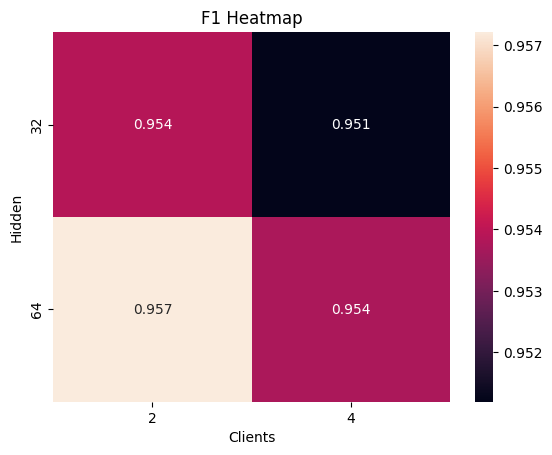

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = results_df.pivot_table(
    values="F1",
    index="Hidden",
    columns="Clients"
)

sns.heatmap(pivot, annot=True, fmt=".3f")
plt.title("F1 Heatmap")
plt.show()


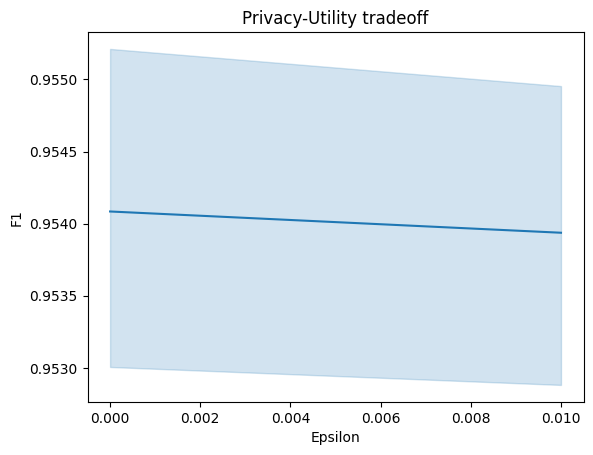

In [7]:
sns.lineplot(x="Epsilon", y="F1", data=results_df)
plt.title("Privacy-Utility tradeoff")
plt.show()


In [3]:
import pandas as pd

data = [
[2.0,32,0.4,0.6,2,0.00,0.915609,0.954379,0.880563,0.464150,0.919724,307.41,1.047],
[2.0,32,0.4,0.6,2,0.01,0.914823,0.953931,0.877125,0.458582,0.919383,304.96,1.048],
[2.0,32,0.4,0.6,4,0.00,0.909554,0.951236,0.852406,0.408482,0.920549,304.19,1.048],
[2.0,32,0.4,0.6,4,0.01,0.909884,0.951416,0.856709,0.411257,0.921583,302.47,1.048],
[2.0,32,0.6,0.4,2,0.00,0.913320,0.953193,0.869885,0.443516,0.933781,306.28,1.047],
[2.0,32,0.6,0.4,2,0.01,0.916384,0.954693,0.881751,0.474029,0.928438,305.90,1.048],
[2.0,32,0.6,0.4,4,0.00,0.910743,0.951885,0.856765,0.418507,0.935242,302.11,1.047],
[2.0,32,0.6,0.4,4,0.01,0.909596,0.951281,0.840511,0.407877,0.935042,301.64,1.048],
[2.0,64,0.4,0.6,2,0.00,0.922319,0.957825,0.902466,0.522177,0.915642,304.56,1.048],
[2.0,64,0.4,0.6,2,0.01,0.921168,0.957229,0.897644,0.512681,0.914361,302.20,1.047],
[2.0,64,0.4,0.6,4,0.00,0.913815,0.953437,0.878945,0.448480,0.916183,299.42,1.047],
[2.0,64,0.4,0.6,4,0.01,0.913602,0.953307,0.881739,0.447295,0.918352,301.71,1.046],
[2.0,64,0.6,0.4,2,0.00,0.921321,0.957314,0.902906,0.513788,0.928645,302.47,1.047],
[2.0,64,0.6,0.4,2,0.01,0.920032,0.956656,0.897212,0.502755,0.930474,303.23,1.047],
[2.0,64,0.6,0.4,4,0.00,0.915658,0.954379,0.883488,0.465420,0.932130,300.94,1.046],
[2.0,64,0.6,0.4,4,0.01,0.913684,0.953363,0.877958,0.447523,0.933337,299.96,1.047],
[2.5,32,0.4,0.6,2,0.00,0.914927,0.953968,0.874963,0.459765,0.917031,304.73,1.047],
[2.5,32,0.4,0.6,2,0.01,0.914287,0.953678,0.868314,0.452478,0.921502,304.31,1.047],
[2.5,32,0.4,0.6,4,0.00,0.908901,0.950901,0.853959,0.401580,0.920925,304.93,1.047],
[2.5,32,0.4,0.6,4,0.01,0.908581,0.950743,0.847566,0.398154,0.920697,310.73,1.048],
[2.5,32,0.6,0.4,2,0.00,0.913553,0.953293,0.870836,0.446032,0.931634,316.42,1.047],
[2.5,32,0.6,0.4,2,0.01,0.914949,0.953986,0.879301,0.459707,0.932226,316.67,1.048],
[2.5,32,0.6,0.4,4,0.00,0.910306,0.951598,0.858906,0.416467,0.933876,316.85,1.047],
[2.5,32,0.6,0.4,4,0.01,0.908114,0.950502,0.847563,0.393481,0.935917,319.91,1.047],
[2.5,64,0.4,0.6,2,0.00,0.921275,0.957334,0.902013,0.511881,0.919244,322.28,1.048],
[2.5,64,0.4,0.6,2,0.01,0.920107,0.956692,0.900492,0.503123,0.917338,318.63,1.047],
[2.5,64,0.4,0.6,4,0.00,0.913917,0.953484,0.882163,0.449219,0.918041,316.72,1.047],
[2.5,64,0.4,0.6,4,0.01,0.914529,0.953831,0.884697,0.453721,0.918726,315.08,1.047],
[2.5,64,0.6,0.4,2,0.00,0.921284,0.957321,0.903689,0.512420,0.929429,320.74,1.047],
[2.5,64,0.6,0.4,2,0.01,0.921326,0.957335,0.899563,0.512973,0.929655,327.81,1.047],
[2.5,64,0.6,0.4,4,0.00,0.914579,0.953802,0.882564,0.456096,0.930954,323.71,1.047],
[2.5,64,0.6,0.4,4,0.01,0.915567,0.954346,0.884762,0.463749,0.930131,322.98,1.047]
]

columns=["Threshold","Hidden","CostWeight","RiskWeight",
         "Clients","Epsilon","Accuracy","F1","ROC","MCC",
         "RiskObj","TrainTime","GPU_Mem_GB"]

df=pd.DataFrame(data,columns=columns)

print(df.head())


   Threshold  Hidden  CostWeight  RiskWeight  Clients  Epsilon  Accuracy  \
0        2.0      32         0.4         0.6        2     0.00  0.915609   
1        2.0      32         0.4         0.6        2     0.01  0.914823   
2        2.0      32         0.4         0.6        4     0.00  0.909554   
3        2.0      32         0.4         0.6        4     0.01  0.909884   
4        2.0      32         0.6         0.4        2     0.00  0.913320   

         F1       ROC       MCC   RiskObj  TrainTime  GPU_Mem_GB  
0  0.954379  0.880563  0.464150  0.919724     307.41       1.047  
1  0.953931  0.877125  0.458582  0.919383     304.96       1.048  
2  0.951236  0.852406  0.408482  0.920549     304.19       1.048  
3  0.951416  0.856709  0.411257  0.921583     302.47       1.048  
4  0.953193  0.869885  0.443516  0.933781     306.28       1.047  


/tmp/ipykernel_55/3789276800.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[2],


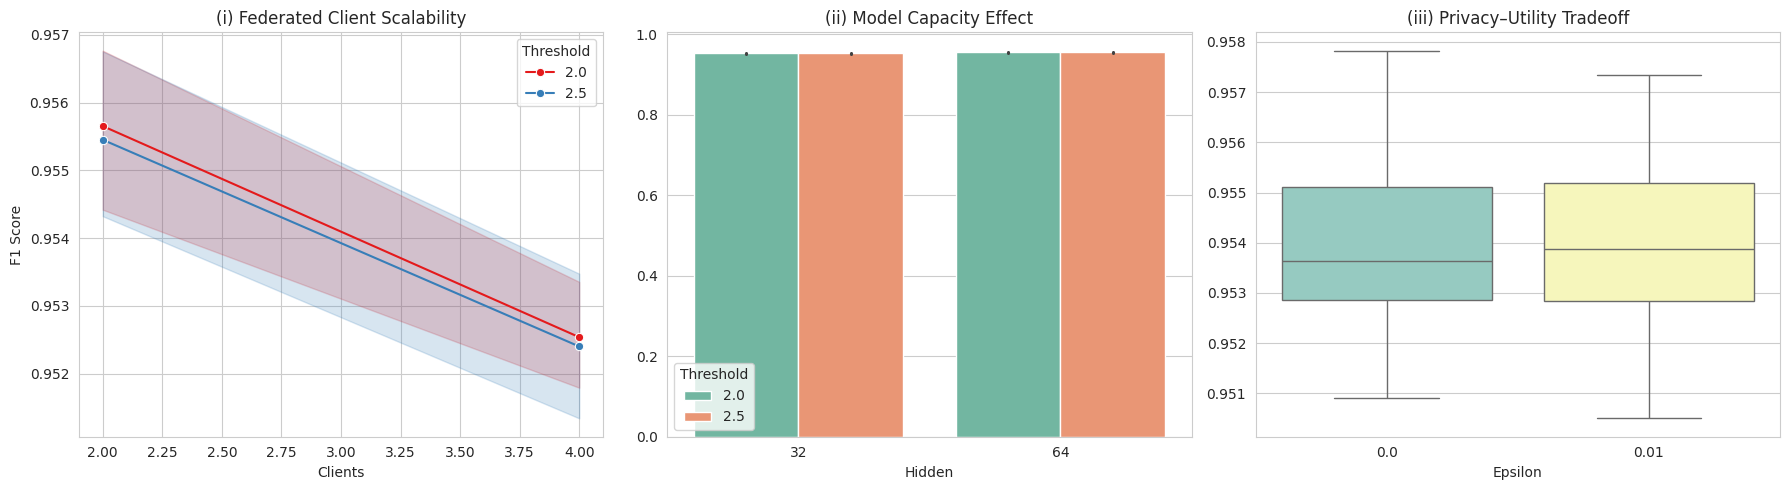

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# =====================================================
# 1️⃣ Client scalability
# =====================================================
sns.lineplot(ax=axes[0],
             x="Clients",
             y="F1",
             hue="Threshold",
             marker="o",
             palette="Set1",
             data=df)

axes[0].set_title("(i) Federated Client Scalability")
axes[0].set_ylabel("F1 Score")

# =====================================================
# 2️⃣ Model capacity
# =====================================================
sns.barplot(ax=axes[1],
            x="Hidden",
            y="F1",
            hue="Threshold",
            palette="Set2",
            data=df)

axes[1].set_title("(ii) Model Capacity Effect")
axes[1].set_ylabel("")

# =====================================================
# 3️⃣ Privacy tradeoff
# =====================================================
sns.boxplot(ax=axes[2],
            x="Epsilon",
            y="F1",
            palette="Set3",
            data=df)

axes[2].set_title("(iii) Privacy–Utility Tradeoff")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


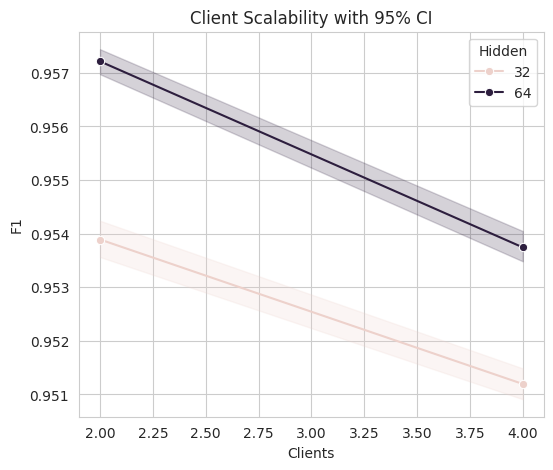

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(6,5))

sns.lineplot(
    x="Clients",
    y="F1",
    hue="Hidden",
    marker="o",
    errorbar=("ci",95),
    data=df
)

plt.title("Client Scalability with 95% CI")
plt.show()


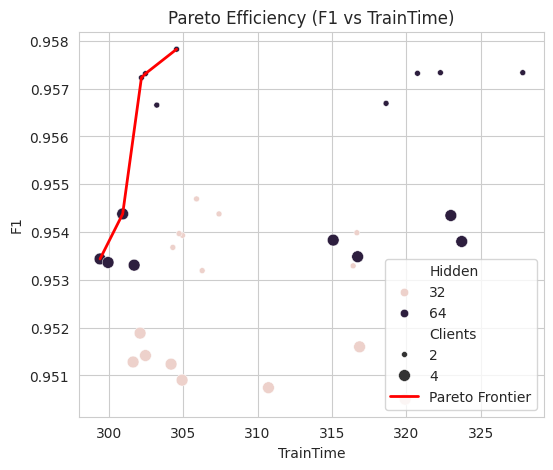

In [7]:
import numpy as np

plt.figure(figsize=(6,5))

# Scatter all models
sns.scatterplot(x="TrainTime",y="F1",
                hue="Hidden",
                size="Clients",
                data=df)

# Compute Pareto frontier
df_sorted=df.sort_values("TrainTime")
pareto=[]
best_f1=0

for _,row in df_sorted.iterrows():
    if row["F1"]>best_f1:
        pareto.append(row)
        best_f1=row["F1"]

pareto_df=pd.DataFrame(pareto)

# Overlay Pareto curve
plt.plot(pareto_df["TrainTime"],
         pareto_df["F1"],
         color="red",
         linewidth=2,
         label="Pareto Frontier")

plt.legend()
plt.title("Pareto Efficiency (F1 vs TrainTime)")
plt.show()


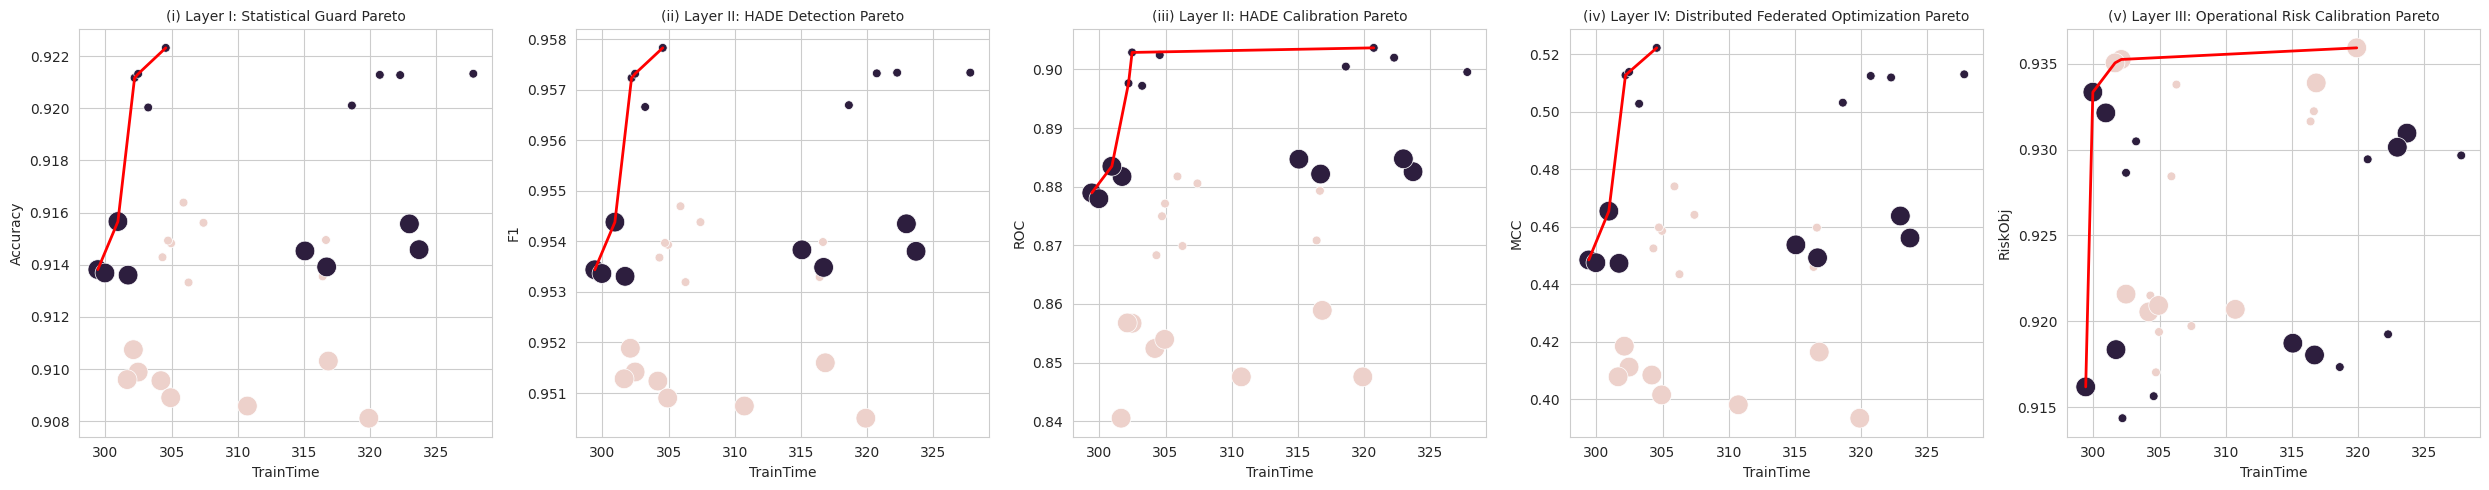

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("whitegrid")

metrics = ["Accuracy","F1","ROC","MCC","RiskObj"]

fig, axes = plt.subplots(1, len(metrics), figsize=(25,5))

for i, metric in enumerate(metrics):

    ax = axes[i]

    # =================================================
    # Scatter plot
    # =================================================
    sns.scatterplot(ax=ax,
                    x="TrainTime",
                    y=metric,
                    hue="Hidden",
                    size="Clients",
                    sizes=(40,200),
                    data=df,
                    legend=False)

    # =================================================
    # Pareto computation
    # =================================================
    df_sorted = df.sort_values("TrainTime")
    pareto = []
    best = -1e9

    for _, row in df_sorted.iterrows():
        if row[metric] > best:
            pareto.append(row)
            best = row[metric]

    pareto_df = pd.DataFrame(pareto)

    # =================================================
    # Pareto line
    # =================================================
    ax.plot(pareto_df["TrainTime"],
            pareto_df[metric],
            color="red",
            linewidth=2)

    # =================================================
    # Paper-aligned titles
    # =================================================
    layer_titles = {
        "Accuracy":"(i) Layer I: Statistical Guard Pareto",
    
        "F1":"(ii) Layer II: HADE Detection Pareto",
        "ROC":"(iii) Layer II: HADE Calibration Pareto",
    
        "MCC":"(iv) Layer IV: Distributed Federated Optimization Pareto",
        "RiskObj":"(v) Layer III: Operational Risk Calibration Pareto"
    }

    ax.set_title(layer_titles[metric], fontsize=10)

plt.tight_layout()
plt.show()


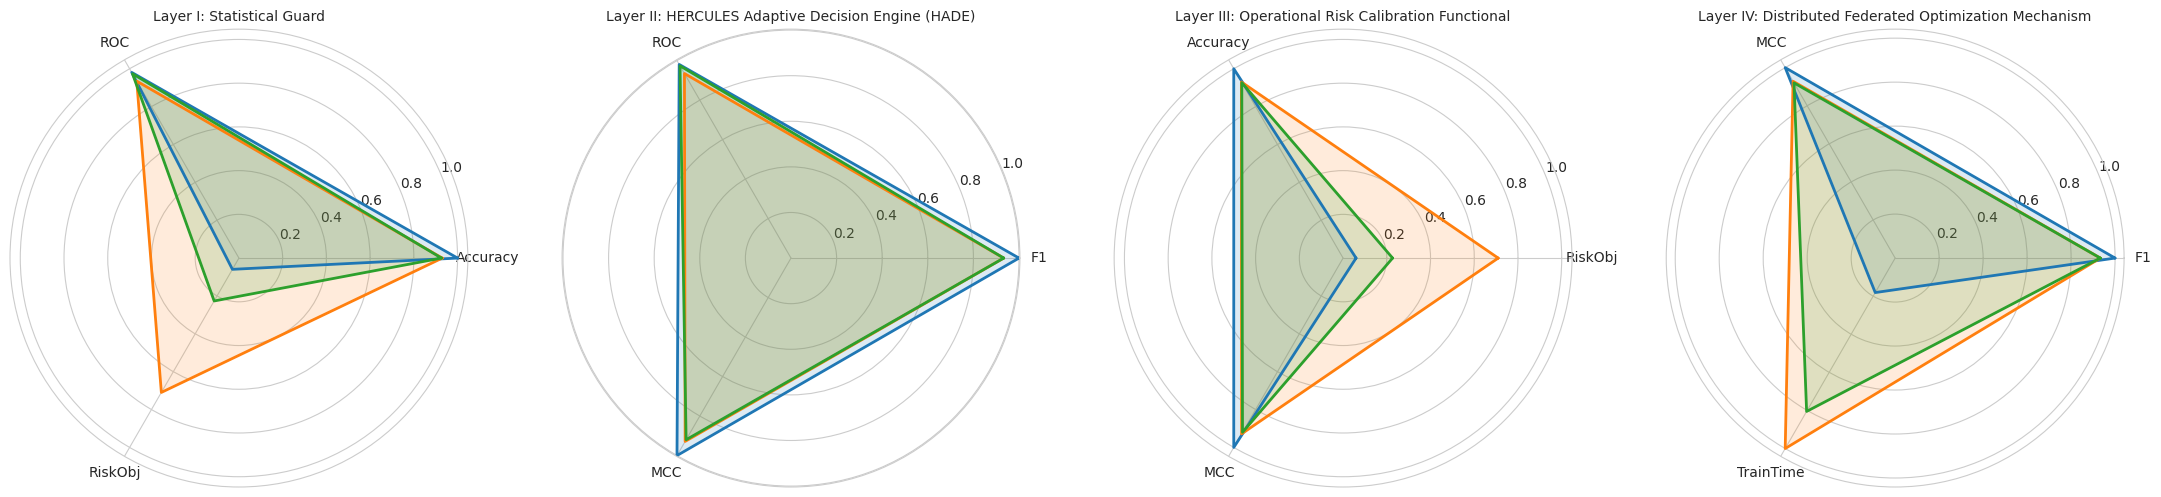

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Select top configs
top = df.sort_values("F1", ascending=False).head(3)

# Layer metrics (paper aligned)
layer_metrics = {
    "Layer I: Statistical Guard": ["Accuracy","ROC","RiskObj"],
    "Layer II: HERCULES Adaptive Decision Engine (HADE)": ["F1","ROC","MCC"],
    "Layer III: Operational Risk Calibration Functional": ["RiskObj","Accuracy","MCC"],
    "Layer IV: Distributed Federated Optimization Mechanism": ["F1","MCC","TrainTime"]
}

# Normalize all radar metrics
scaler = MinMaxScaler()
metrics_all = list(set(sum(layer_metrics.values(), [])))
df_scaled = df.copy()
df_scaled[metrics_all] = scaler.fit_transform(df[metrics_all])

top_scaled = df_scaled.loc[top.index]

colors = ["#1f77b4","#ff7f0e","#2ca02c"]

fig, axes = plt.subplots(1, 4, subplot_kw=dict(polar=True), figsize=(22,5))

for ax, (layer, metrics) in zip(axes, layer_metrics.items()):

    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    for i, row in top_scaled.iterrows():
        values = row[metrics].tolist()
        values += values[:1]

        color = colors[list(top_scaled.index).index(i)]

        ax.plot(angles, values, color=color, linewidth=2)
        ax.fill(angles, values, color=color, alpha=0.15)

    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title(layer, fontsize=10)

plt.tight_layout()
plt.show()


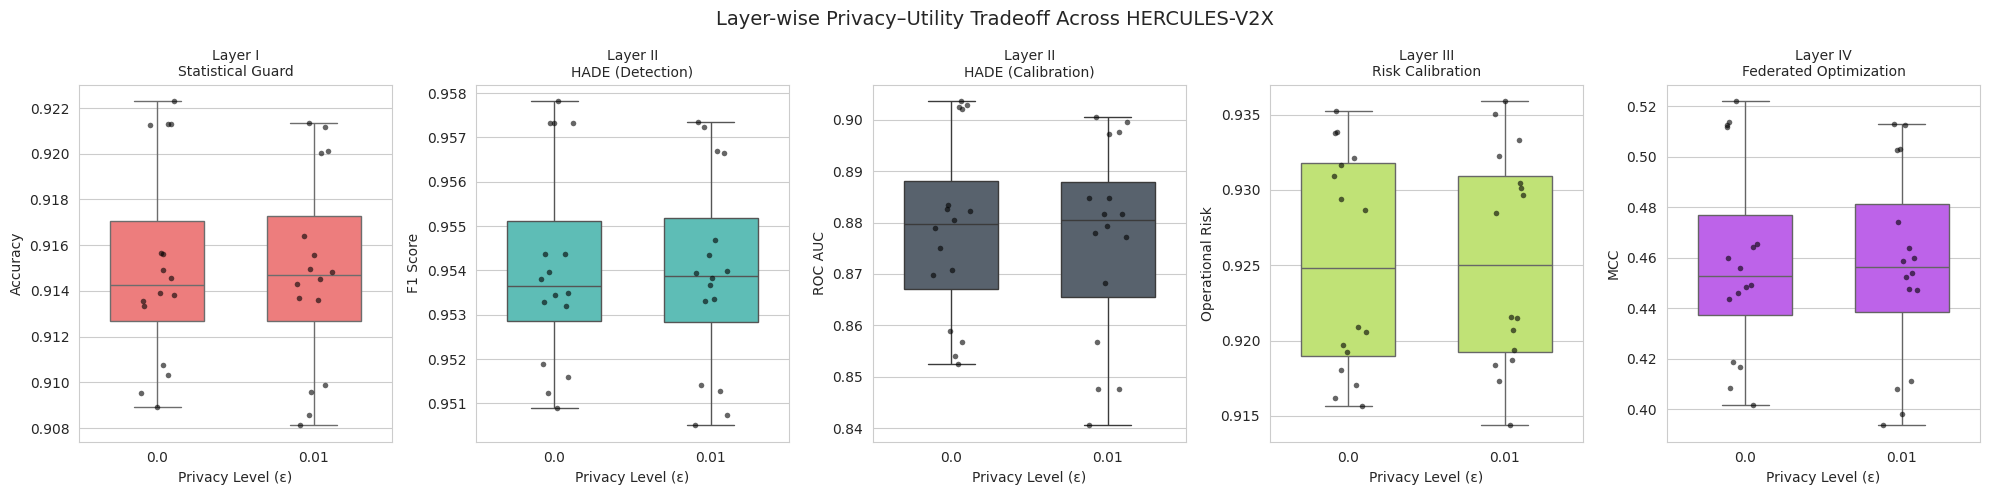

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

metrics = ["Accuracy","F1","ROC","RiskObj","MCC"]

layer_titles = [
    "Layer I\nStatistical Guard",
    "Layer II\nHADE (Detection)",
    "Layer II\nHADE (Calibration)",
    "Layer III\nRisk Calibration",
    "Layer IV\nFederated Optimization"
]

y_labels = [
    "Accuracy",
    "F1 Score",
    "ROC AUC",
    "Operational Risk",
    "MCC"
]

colors = ["#ff6b6b","#4ecdc4","#556270","#c7f464","#c44dff"]

fig, axes = plt.subplots(1, len(metrics), figsize=(20,5))

for i, metric in enumerate(metrics):

    sns.boxplot(
        ax=axes[i],
        x="Epsilon",
        y=metric,
        data=df,
        color=colors[i],
        width=0.6
    )

    sns.stripplot(
        ax=axes[i],
        x="Epsilon",
        y=metric,
        data=df,
        color="black",
        jitter=0.12,
        size=4,
        alpha=0.6
    )

    axes[i].set_title(layer_titles[i], fontsize=10)
    axes[i].set_xlabel("Privacy Level (ε)")
    axes[i].set_ylabel(y_labels[i])

plt.suptitle("Layer-wise Privacy–Utility Tradeoff Across HERCULES-V2X", fontsize=14)
plt.tight_layout()
plt.show()


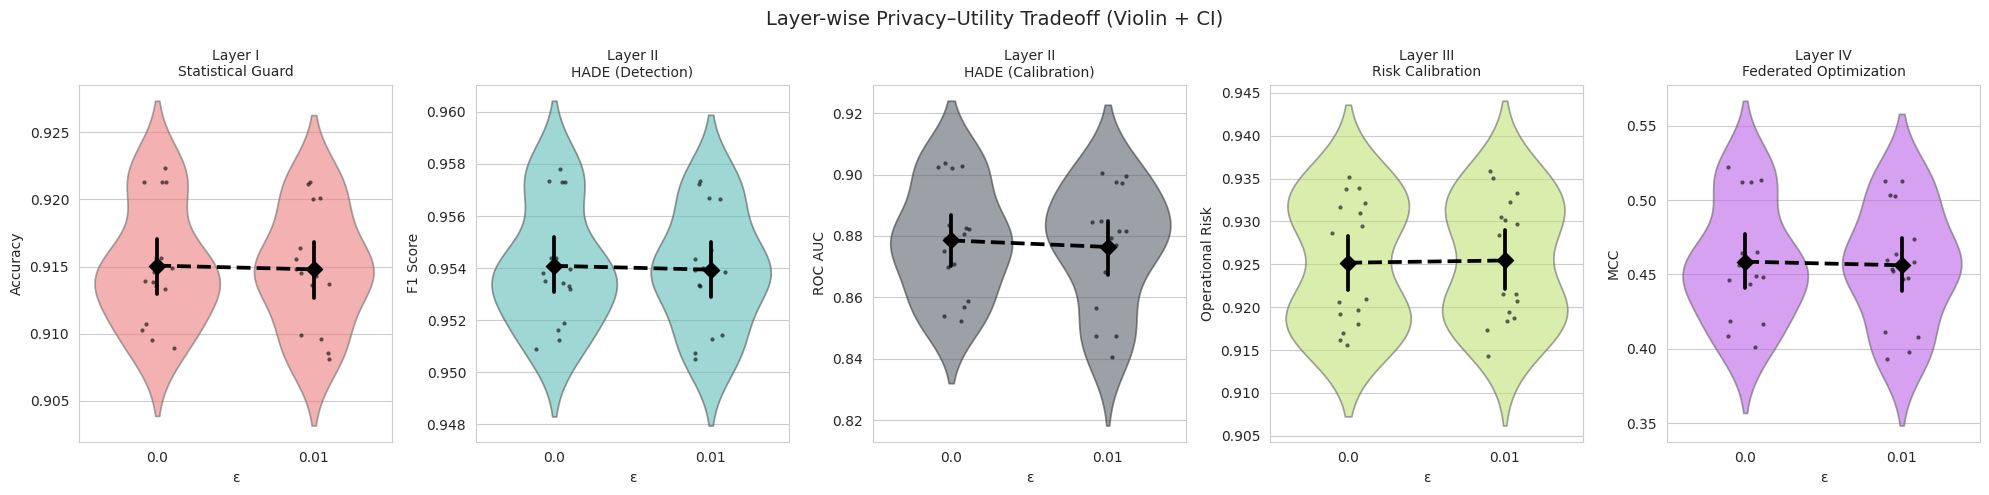

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

metrics = ["Accuracy","F1","ROC","RiskObj","MCC"]

layer_titles = [
    "Layer I\nStatistical Guard",
    "Layer II\nHADE (Detection)",
    "Layer II\nHADE (Calibration)",
    "Layer III\nRisk Calibration",
    "Layer IV\nFederated Optimization"
]

y_labels = [
    "Accuracy",
    "F1 Score",
    "ROC AUC",
    "Operational Risk",
    "MCC"
]

colors = ["#ff6b6b","#4ecdc4","#556270","#c7f464","#c44dff"]

fig, axes = plt.subplots(1, len(metrics), figsize=(20,5))

for i, metric in enumerate(metrics):

    # Violin
    sns.violinplot(
        ax=axes[i],
        x="Epsilon",
        y=metric,
        data=df,
        color=colors[i],
        inner=None,
        alpha=0.6
    )

    # Raw points
    sns.stripplot(
        ax=axes[i],
        x="Epsilon",
        y=metric,
        data=df,
        color="black",
        jitter=0.12,
        size=3,
        alpha=0.6
    )

    # Mean + CI
    sns.pointplot(
        ax=axes[i],
        x="Epsilon",
        y=metric,
        data=df,
        color="black",
        errorbar=("ci",95),
        markers="D",
        linestyles="--"
    )

    axes[i].set_title(layer_titles[i], fontsize=10)
    axes[i].set_xlabel("ε")
    axes[i].set_ylabel(y_labels[i])

plt.suptitle("Layer-wise Privacy–Utility Tradeoff (Violin + CI)", fontsize=14)
plt.tight_layout()
plt.show()


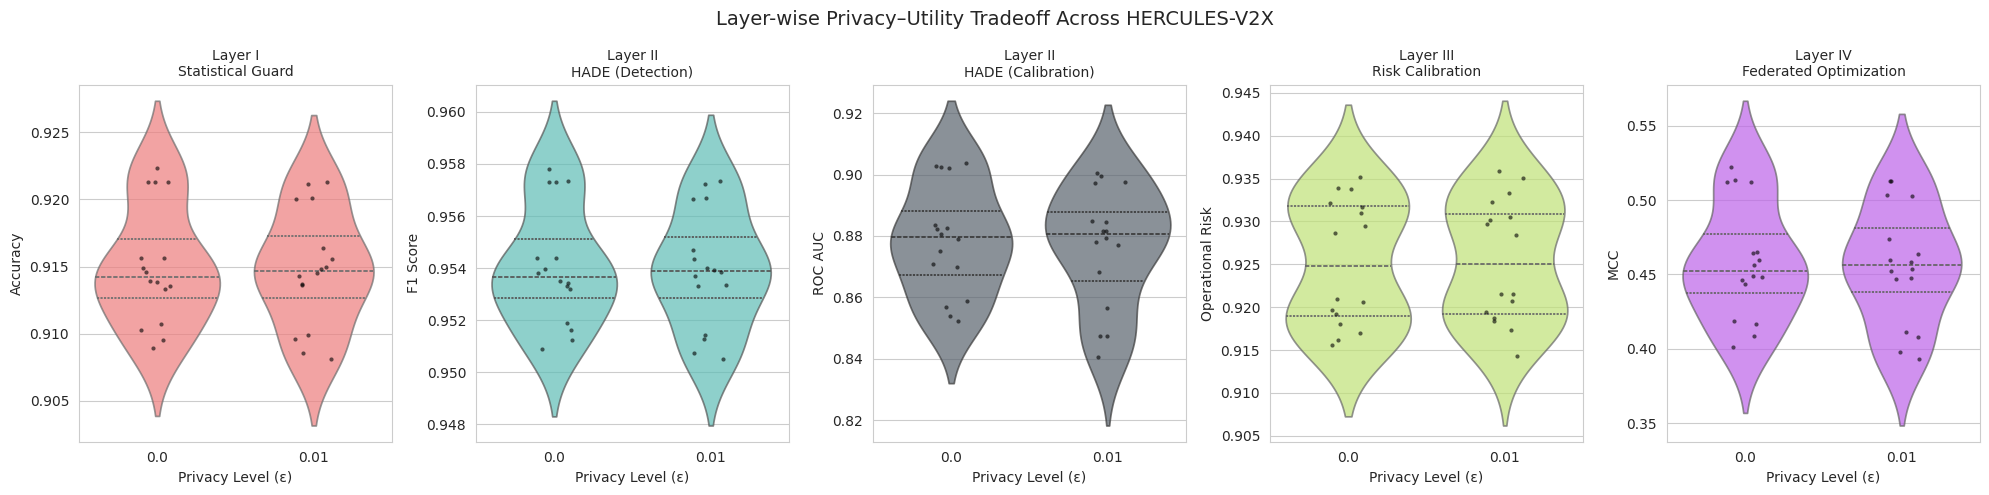

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

metrics = ["Accuracy","F1","ROC","RiskObj","MCC"]

layer_titles = [
    "Layer I\nStatistical Guard",
    "Layer II\nHADE (Detection)",
    "Layer II\nHADE (Calibration)",
    "Layer III\nRisk Calibration",
    "Layer IV\nFederated Optimization"
]

y_labels = [
    "Accuracy",
    "F1 Score",
    "ROC AUC",
    "Operational Risk",
    "MCC"
]

colors = ["#ff6b6b","#4ecdc4","#556270","#c7f464","#c44dff"]

fig, axes = plt.subplots(1, len(metrics), figsize=(20,5))

for i, metric in enumerate(metrics):

    # =====================================================
    # Violin distribution
    # =====================================================
    sns.violinplot(
        ax=axes[i],
        x="Epsilon",
        y=metric,
        data=df,
        color=colors[i],
        inner="quartile",
        alpha=0.7
    )

    # =====================================================
    # Raw configs overlay
    # =====================================================
    sns.stripplot(
        ax=axes[i],
        x="Epsilon",
        y=metric,
        data=df,
        color="black",
        jitter=0.12,
        size=3,
        alpha=0.6
    )

    axes[i].set_title(layer_titles[i], fontsize=10)
    axes[i].set_xlabel("Privacy Level (ε)")
    axes[i].set_ylabel(y_labels[i])

plt.suptitle("Layer-wise Privacy–Utility Tradeoff Across HERCULES-V2X", fontsize=14)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

# =====================================================
# Privacy sensitivity helper
# =====================================================
def privacy_delta(metric):
    g = df.groupby("Epsilon")[metric].mean()
    return abs(g.iloc[0] - g.iloc[1])

# =====================================================
# Layer effectiveness table
# =====================================================
layer_effectiveness = pd.DataFrame({

    "Layer": [
        "Layer I: Statistical Guard",
        "Layer II: HADE",
        "Layer III: Risk Calibration",
        "Layer IV: Federated Optimization"
    ],

    "Primary Metric": [
        "Accuracy",
        "F1+ROC",
        "RiskObj",
        "MCC+TrainTime"
    ],

    "Mean Performance": [
        df["Accuracy"].mean(),
        (df["F1"].mean()+df["ROC"].mean())/2,
        df["RiskObj"].mean(),
        (df["MCC"].mean()+1-df["TrainTime"].rank(pct=True).mean())/2
    ],

    "Robustness (Std)": [
        df["Accuracy"].std(),
        (df["F1"].std()+df["ROC"].std())/2,
        df["RiskObj"].std(),
        (df["MCC"].std()+df["TrainTime"].std())/2
    ],

    "Best Config": [
        df["Accuracy"].max(),
        (df["F1"].max()+df["ROC"].max())/2,
        df["RiskObj"].min(),
        df["MCC"].max()
    ],

    "Privacy Sensitivity (Δε)": [
        privacy_delta("Accuracy"),
        (privacy_delta("F1")+privacy_delta("ROC"))/2,
        privacy_delta("RiskObj"),
        privacy_delta("MCC")
    ]
})

layer_effectiveness


,Layer,Primary Metric,Mean Performance,Robustness (Std),Best Config,Privacy Sensitivity (Δε)
0,Layer I: Statistical Guard,Accuracy,0.914929,0.004280,0.922319,0.000278
1,Layer II: HADE,F1+ROC,0.915746,0.010242,0.930757,0.001124
2,Layer III: Risk Calibration,RiskObj,0.925318,0.007085,0.914361,0.000258
3,Layer IV: Federated Optimization,MCC+TrainTime,0.470896,4.271609,0.522177,0.002412


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# =====================================================
# 1️⃣ Privacy Robustness Index (PRI)
# =====================================================
def PRI(metric):
    g = df.groupby("Epsilon")[metric].mean()
    return 1 - abs(g.iloc[0] - g.iloc[1]) / g.iloc[0]

PRI_metrics = {
    "PRI_Accuracy": PRI("Accuracy"),
    "PRI_F1": PRI("F1"),
    "PRI_ROC": PRI("ROC"),
    "PRI_MCC": PRI("MCC")
}

# =====================================================
# 2️⃣ Federated Scalability Index (FSI)
# =====================================================
def FSI(metric):
    g = df.groupby("Clients")[metric].mean()
    return 1 - abs(g.iloc[0] - g.iloc[1]) / g.iloc[0]

FSI_metrics = {
    "FSI_F1": FSI("F1"),
    "FSI_ROC": FSI("ROC"),
    "FSI_MCC": FSI("MCC")
}

# =====================================================
# 3️⃣ Detection–Risk Harmony (DRH)
# =====================================================
df["DRH"] = (df["F1"] + (1 - df["RiskObj"])) / 2

# =====================================================
# 4️⃣ Layer Contribution Stability (LCS)
# =====================================================
LCS_metrics = {
    "LCS_Accuracy": 1 - df["Accuracy"].std(),
    "LCS_F1": 1 - df["F1"].std(),
    "LCS_ROC": 1 - df["ROC"].std(),
    "LCS_MCC": 1 - df["MCC"].std()
}

# =====================================================
# 5️⃣ Federated Efficiency Score (FES)
# =====================================================
df["FES"] = df["MCC"] / df["TrainTime"]

# =====================================================
# 6️⃣ Multi-objective Dominance Score (MODS)
# =====================================================
scaler = MinMaxScaler()
norm = scaler.fit_transform(df[["F1","ROC","MCC","Accuracy"]])
df["MODS"] = norm.mean(axis=1)

# =====================================================
# 7️⃣ Privacy–Federation Interaction (PFI)
# =====================================================
PFI = abs(
    df.groupby(["Clients","Epsilon"])["F1"]
      .mean()
      .unstack()
      .diff(axis=1)
).mean().mean()

# =====================================================
# 8️⃣ Calibration Stability Metric (CSM)
# =====================================================
CSM = 1 - df["ROC"].std()

# =====================================================
# FINAL SUMMARY TABLE
# =====================================================
novel_summary = pd.DataFrame({
    **PRI_metrics,
    **FSI_metrics,
    **LCS_metrics,
    "PFI": [PFI],
    "CSM": [CSM]
})

print("\n===== Novel Metric Summary =====")
print(novel_summary.round(4))

print("\n===== Sample Rows with Added Metrics =====")
print(df[["DRH","FES","MODS"]].head())



===== Novel Metric Summary =====
   PRI_Accuracy  PRI_F1  PRI_ROC  PRI_MCC  FSI_F1  FSI_ROC  FSI_MCC  \
0        0.9997  0.9998   0.9976   0.9947  0.9968   0.9762   0.8887   

   LCS_Accuracy  LCS_F1  LCS_ROC  LCS_MCC     PFI     CSM  
0        0.9957  0.9978   0.9817   0.9616  0.0001  0.9817  

===== Sample Rows with Added Metrics =====
        DRH       FES      MODS
0  0.517327  0.001510  0.560032
1  0.517274  0.001504  0.506484
2  0.515343  0.001343  0.126611
3  0.514916  0.001360  0.160982
4  0.509706  0.001448  0.396922


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df_enh = df.copy()

# =====================================================
# 1️⃣ Row-level Privacy Robustness Index (PRI)
# =====================================================
mean_eps = df.groupby("Epsilon")[["Accuracy","F1","ROC","MCC"]].mean()

df_enh["PRI_Accuracy"] = 1 - abs(df_enh["Accuracy"] -
                                 mean_eps.loc[df_enh["Epsilon"],"Accuracy"].values) \
                                 / mean_eps.loc[df_enh["Epsilon"],"Accuracy"].values

df_enh["PRI_F1"] = 1 - abs(df_enh["F1"] -
                           mean_eps.loc[df_enh["Epsilon"],"F1"].values) \
                           / mean_eps.loc[df_enh["Epsilon"],"F1"].values

df_enh["PRI_ROC"] = 1 - abs(df_enh["ROC"] -
                            mean_eps.loc[df_enh["Epsilon"],"ROC"].values) \
                            / mean_eps.loc[df_enh["Epsilon"],"ROC"].values

df_enh["PRI_MCC"] = 1 - abs(df_enh["MCC"] -
                            mean_eps.loc[df_enh["Epsilon"],"MCC"].values) \
                            / mean_eps.loc[df_enh["Epsilon"],"MCC"].values

# =====================================================
# 2️⃣ Row-level Federated Scalability Index (FSI)
# =====================================================
mean_clients = df.groupby("Clients")[["F1","ROC","MCC"]].mean()

df_enh["FSI_F1"] = 1 - abs(df_enh["F1"] -
                           mean_clients.loc[df_enh["Clients"],"F1"].values) \
                           / mean_clients.loc[df_enh["Clients"],"F1"].values

df_enh["FSI_ROC"] = 1 - abs(df_enh["ROC"] -
                            mean_clients.loc[df_enh["Clients"],"ROC"].values) \
                            / mean_clients.loc[df_enh["Clients"],"ROC"].values

df_enh["FSI_MCC"] = 1 - abs(df_enh["MCC"] -
                            mean_clients.loc[df_enh["Clients"],"MCC"].values) \
                            / mean_clients.loc[df_enh["Clients"],"MCC"].values

# =====================================================
# 3️⃣ Detection–Risk Harmony (DRH)
# =====================================================
df_enh["DRH"] = (df_enh["F1"] + (1 - df_enh["RiskObj"])) / 2

# =====================================================
# 4️⃣ Layer Contribution Stability (LCS) – global but repeated
# =====================================================
for metric in ["Accuracy","F1","ROC","MCC"]:
    df_enh[f"LCS_{metric}"] = 1 - df[metric].std()

# =====================================================
# 5️⃣ Federated Efficiency Score (FES)
# =====================================================
df_enh["FES"] = df_enh["MCC"] / df_enh["TrainTime"]

# =====================================================
# 6️⃣ Multi-objective Dominance Score (MODS)
# =====================================================
scaler = MinMaxScaler()
norm = scaler.fit_transform(df_enh[["F1","ROC","MCC","Accuracy"]])
df_enh["MODS"] = norm.mean(axis=1)

# =====================================================
# 7️⃣ Privacy–Federation Interaction (row version)
# =====================================================
pf_table = df.groupby(["Clients","Epsilon"])["F1"].mean().reset_index()
pf_table.rename(columns={"F1":"F1_group_mean"}, inplace=True)

df_enh = df_enh.merge(pf_table, on=["Clients","Epsilon"], how="left")

df_enh["PFI"] = abs(df_enh["F1"] - df_enh["F1_group_mean"])

df_enh.drop(columns=["F1_group_mean"], inplace=True)


# =====================================================
# 8️⃣ Calibration Stability Metric (CSM)
# =====================================================
df_enh["CSM"] = 1 - df["ROC"].std()

# =====================================================
# FINAL OUTPUT
# =====================================================
print("\n===== Enhanced Configuration Table =====")
print(df_enh.round(4))



===== Enhanced Configuration Table =====
    Threshold  Hidden  CostWeight  RiskWeight  Clients  Epsilon  Accuracy  \
0         2.0      32         0.4         0.6        2     0.00    0.9156   
1         2.0      32         0.4         0.6        2     0.01    0.9148   
2         2.0      32         0.4         0.6        4     0.00    0.9096   
3         2.0      32         0.4         0.6        4     0.01    0.9099   
4         2.0      32         0.6         0.4        2     0.00    0.9133   
5         2.0      32         0.6         0.4        2     0.01    0.9164   
6         2.0      32         0.6         0.4        4     0.00    0.9107   
7         2.0      32         0.6         0.4        4     0.01    0.9096   
8         2.0      64         0.4         0.6        2     0.00    0.9223   
9         2.0      64         0.4         0.6        2     0.01    0.9212   
10        2.0      64         0.4         0.6        4     0.00    0.9138   
11        2.0      64         0.4 

In [13]:
df_enh = df_enh.rename(columns={

    # ==============================
    # PRI → Privacy Robustness
    # ==============================
    "PRI_Accuracy": "PrivacyRobust_Accuracy",
    "PRI_F1": "PrivacyRobust_F1",
    "PRI_ROC": "PrivacyRobust_ROC",
    "PRI_MCC": "PrivacyRobust_MCC",

    # ==============================
    # FSI → Federated Scalability
    # ==============================
    "FSI_F1": "FLScalability_F1",
    "FSI_ROC": "FLScalability_ROC",
    "FSI_MCC": "FLScalability_MCC",

    # ==============================
    # LCS → Layer Stability
    # ==============================
    "LCS_Accuracy": "LayerStability_Accuracy",
    "LCS_F1": "LayerStability_F1",
    "LCS_ROC": "LayerStability_ROC",
    "LCS_MCC": "LayerStability_MCC"
})

print("\n===== Updated Column Names =====")
print(df_enh.columns)



===== Updated Column Names =====
Index(['Threshold', 'Hidden', 'CostWeight', 'RiskWeight', 'Clients', 'Epsilon',
       'Accuracy', 'F1', 'ROC', 'MCC', 'RiskObj', 'TrainTime', 'GPU_Mem_GB',
       'DRH', 'FES', 'MODS', 'PrivacyRobust_Accuracy', 'PrivacyRobust_F1',
       'PrivacyRobust_ROC', 'PrivacyRobust_MCC', 'FLScalability_F1',
       'FLScalability_ROC', 'FLScalability_MCC', 'LayerStability_Accuracy',
       'LayerStability_F1', 'LayerStability_ROC', 'LayerStability_MCC', 'PFI',
       'CSM'],
      dtype='object')


In [14]:
# Save full dataframe to txt
file_path = "/kaggle/working/HERCULES_V2X_full_metrics.txt"

df_enh.to_csv(
    file_path,
    sep="\t",        # tab separated (clean for Excel & LaTeX)
    index=False,
    float_format="%.6f"
)

print(f"File saved as {file_path}")


File saved as /kaggle/working/HERCULES_V2X_full_metrics.txt


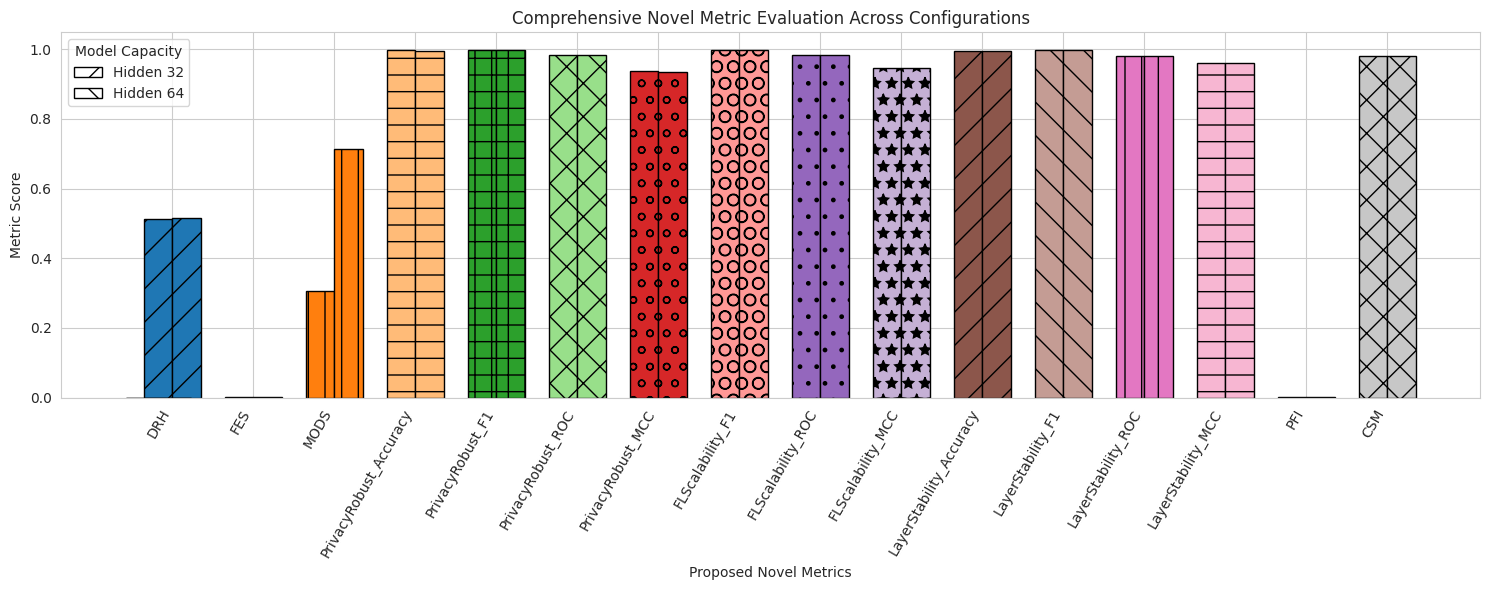

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

metrics = [
    'DRH','FES','MODS',
    'PrivacyRobust_Accuracy','PrivacyRobust_F1','PrivacyRobust_ROC','PrivacyRobust_MCC',
    'FLScalability_F1','FLScalability_ROC','FLScalability_MCC',
    'LayerStability_Accuracy','LayerStability_F1','LayerStability_ROC','LayerStability_MCC',
    'PFI','CSM'
]

# Aggregate by hidden size
plot_df = df_enh.groupby("Hidden")[metrics].mean()

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(15,6))

# Unique colors + hatch patterns
colors = sns.color_palette("tab20", len(metrics))
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

for i, hidden in enumerate(plot_df.index):
    for j, metric in enumerate(metrics):
        ax.bar(
            x[j] + i*width,
            plot_df.loc[hidden, metric],
            width,
            color=colors[j],
            hatch=hatches[j % len(hatches)],
            edgecolor="black"
        )

# Labels
ax.set_ylabel("Metric Score")
ax.set_xlabel("Proposed Novel Metrics")
ax.set_xticks(x + width/2)
ax.set_xticklabels(metrics, rotation=60, ha="right")

# Legend for hidden
for i, hidden in enumerate(plot_df.index):
    ax.bar(0, 0, color="white", edgecolor="black",
           hatch=hatches[i], label=f"Hidden {hidden}")

ax.legend(title="Model Capacity")
ax.set_title("Comprehensive Novel Metric Evaluation Across Configurations")

plt.tight_layout()
plt.show()


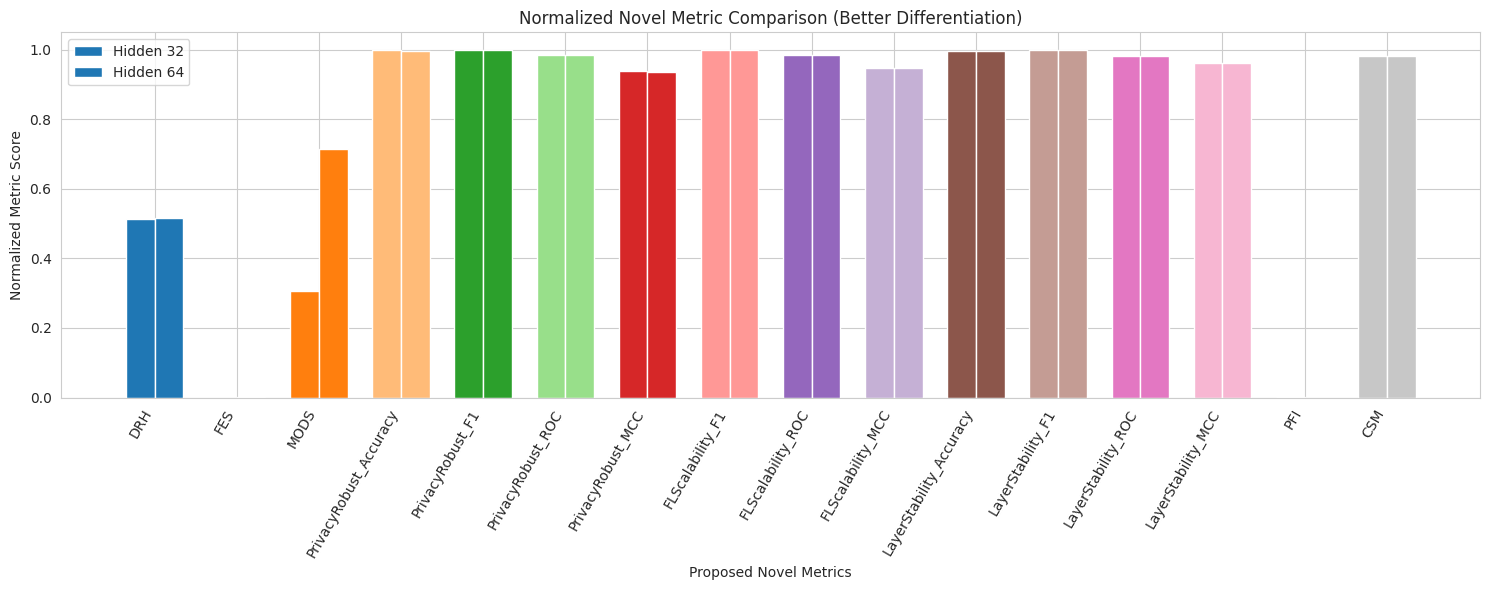

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

metrics = [
    'DRH','FES','MODS',
    'PrivacyRobust_Accuracy','PrivacyRobust_F1','PrivacyRobust_ROC','PrivacyRobust_MCC',
    'FLScalability_F1','FLScalability_ROC','FLScalability_MCC',
    'LayerStability_Accuracy','LayerStability_F1','LayerStability_ROC','LayerStability_MCC',
    'PFI','CSM'
]

plot_df = df_enh.groupby("Hidden")[metrics].mean()

# Normalize
scaler = MinMaxScaler()
plot_norm = pd.DataFrame(
    scaler.fit_transform(plot_df.T).T,
    columns=metrics,
    index=plot_df.index
)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(15,6))
colors = sns.color_palette("tab20", len(metrics))

for i, hidden in enumerate(plot_norm.index):
    ax.bar(x + i*width, plot_norm.loc[hidden], width,
           label=f"Hidden {hidden}", color=colors)

ax.set_ylabel("Normalized Metric Score")
ax.set_xlabel("Proposed Novel Metrics")
ax.set_xticks(x + width/2)
ax.set_xticklabels(metrics, rotation=60, ha="right")
ax.legend()
ax.set_title("Normalized Novel Metric Comparison (Better Differentiation)")

plt.tight_layout()
plt.show()


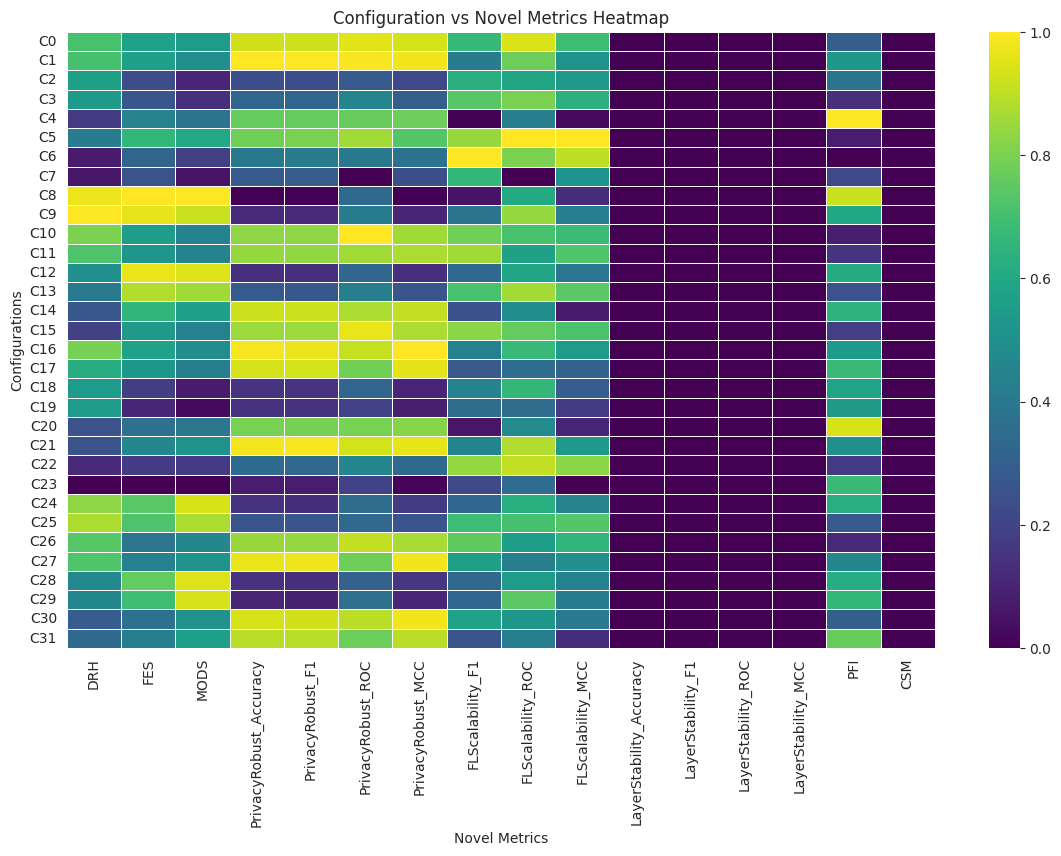

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

metrics = [
    'DRH','FES','MODS',
    'PrivacyRobust_Accuracy','PrivacyRobust_F1','PrivacyRobust_ROC','PrivacyRobust_MCC',
    'FLScalability_F1','FLScalability_ROC','FLScalability_MCC',
    'LayerStability_Accuracy','LayerStability_F1','LayerStability_ROC','LayerStability_MCC',
    'PFI','CSM'
]

# Normalize for visibility
scaler = MinMaxScaler()
heat_data = pd.DataFrame(
    scaler.fit_transform(df_enh[metrics]),
    columns=metrics
)

# Optional: label configs
heat_data.index = [f"C{i}" for i in range(len(heat_data))]

plt.figure(figsize=(14,8))
sns.heatmap(
    heat_data,
    cmap="viridis",
    linewidths=0.5,
    linecolor="white"
)

plt.title("Configuration vs Novel Metrics Heatmap")
plt.xlabel("Novel Metrics")
plt.ylabel("Configurations")
plt.show()


<Axes: >

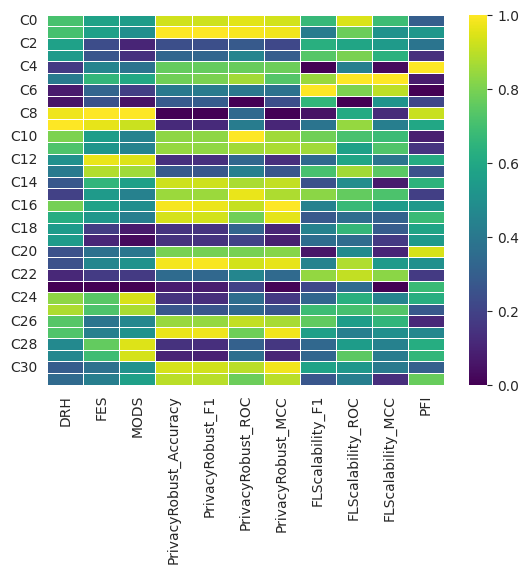

In [20]:
# Remove constant columns
heat_data = heat_data.loc[:, heat_data.nunique() > 1]

sns.heatmap(heat_data, cmap="viridis", linewidths=0.5)


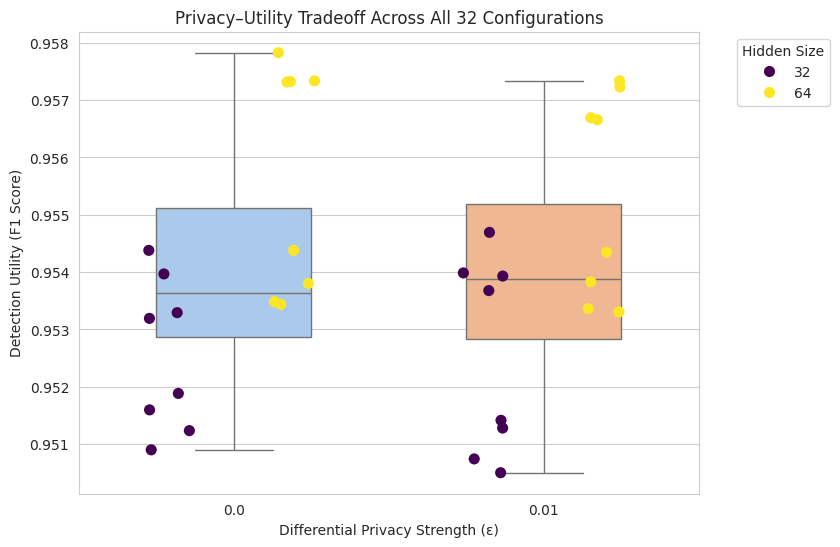

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(8,6))

# =====================================================
# Boxplot background (distribution)
# =====================================================
sns.boxplot(
    x="Epsilon",
    y="F1",
    hue="Epsilon",        # fixes palette warning
    data=df,
    palette="pastel",
    width=0.5,
    legend=False
)

# =====================================================
# Stripplot overlay (all 32 configs)
# =====================================================
sns.stripplot(
    x="Epsilon",
    y="F1",
    hue="Hidden",         # color by model capacity
    dodge=True,
    jitter=0.15,
    size=8,
    palette="viridis",
    data=df
)

plt.title("Privacy–Utility Tradeoff Across All 32 Configurations")
plt.xlabel("Differential Privacy Strength (ε)")
plt.ylabel("Detection Utility (F1 Score)")
plt.legend(title="Hidden Size", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


<Axes: xlabel='Epsilon', ylabel='F1'>

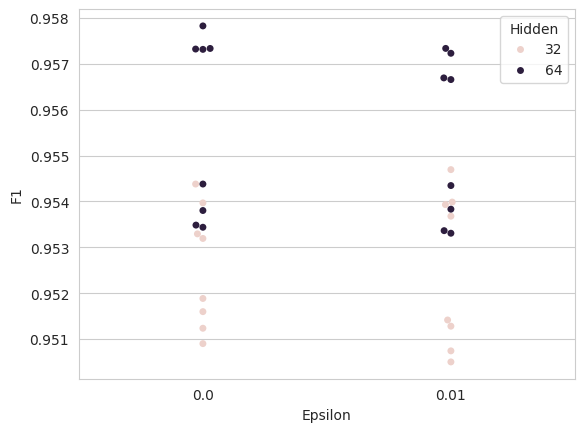

In [26]:
sns.swarmplot(x="Epsilon", y="F1", hue="Hidden", data=df)


<Axes: xlabel='Epsilon', ylabel='F1'>

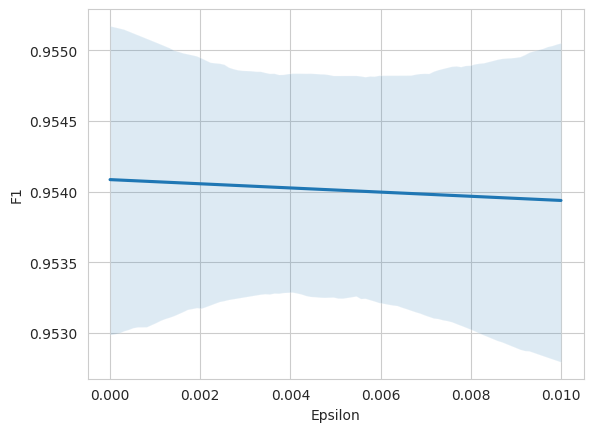

In [27]:
sns.regplot(x="Epsilon", y="F1", scatter=False, data=df)


<Axes: xlabel='Epsilon', ylabel='F1'>

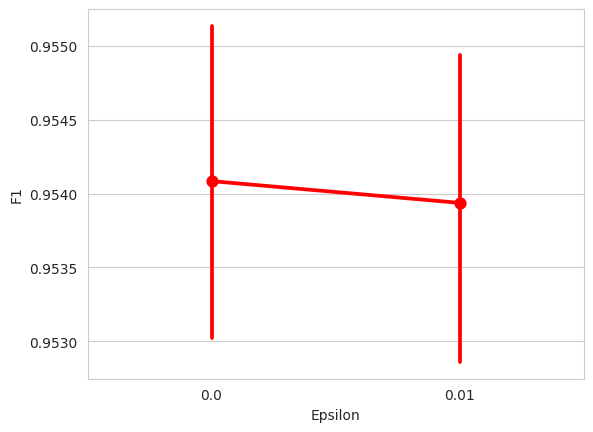

In [28]:
sns.pointplot(x="Epsilon", y="F1", data=df, color="red")


<Axes: xlabel='Epsilon', ylabel='F1'>

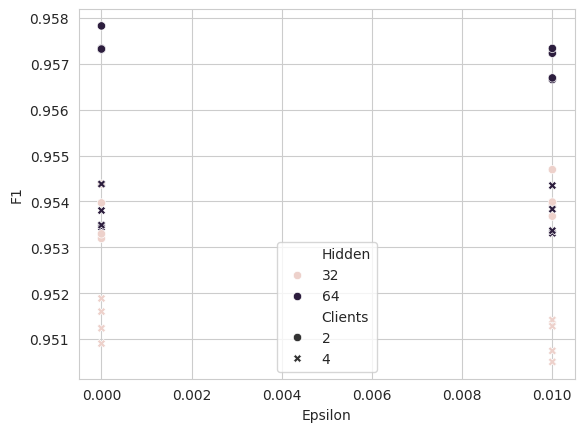

In [29]:
sns.scatterplot(x="Epsilon", y="F1", hue="Hidden", style="Clients", data=df)


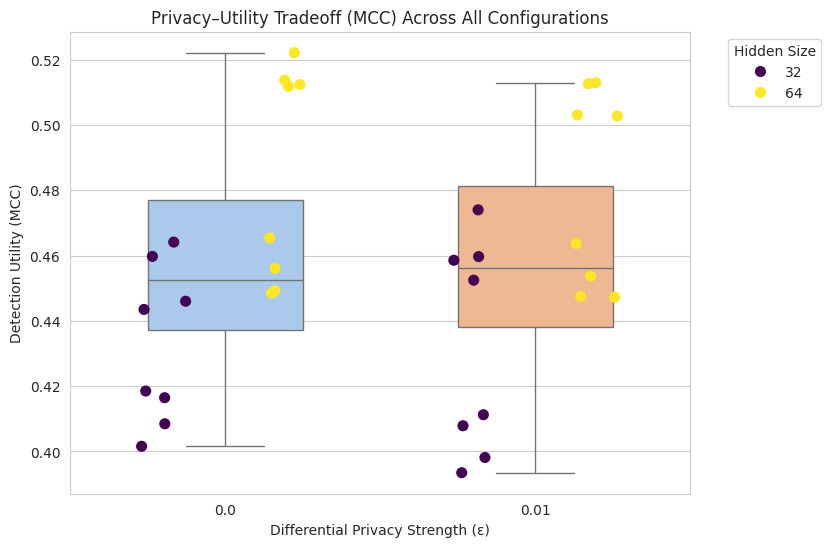

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(8,6))

# =====================================================
# Boxplot (distribution)
# =====================================================
sns.boxplot(
    x="Epsilon",
    y="MCC",
    hue="Epsilon",
    data=df,
    palette="pastel",
    width=0.5,
    legend=False
)

# =====================================================
# Stripplot overlay (all configs)
# =====================================================
sns.stripplot(
    x="Epsilon",
    y="MCC",
    hue="Hidden",
    dodge=True,
    jitter=0.15,
    size=8,
    palette="viridis",
    data=df
)

plt.title("Privacy–Utility Tradeoff (MCC) Across All Configurations")
plt.xlabel("Differential Privacy Strength (ε)")
plt.ylabel("Detection Utility (MCC)")
plt.legend(title="Hidden Size", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
